In [1]:
### Load packages ###
import matplotlib.pyplot as plt
from scipy import stats
import nibabel as nib
import numpy as np
import os

### Aux. Functions ###
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
      axes[i].imshow(slice.T, cmap="gray", origin="lower")

def show_slice(slice):
    plt.imshow(slice.T, cmap="gray", origin="lower")
    
def normalizeImg(x):
    # Normalize x
    max_val = np.max(x)
    min_val = np.min(x)
    norm_x = (x-min_val)/(max_val-min_val + 1e-7)
    return norm_x

def thresholdMask(mask, threshold=0.56):
    mask[mask >= threshold] = 1.0
    mask[mask < threshold] = 0.0
    return mask

%matplotlib inline





/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
### Load Data ###
# nii files
norm_img_nii = nib.load('../data/IXI002-Guys-0828-T1.nii') 
def_img_nii = nib.load('../data/IXI002-Guys-0828-T1_defaced.nii')
mask_img_nii = nib.load('../data/IXI002-Guys-0828-T1_mask.nii.gz')
# img data
norm_img = norm_img_nii.get_data()
def_img = def_img_nii.get_data()
mask_img = mask_img_nii.get_data()

### Data Size ###
print('Norm. Vol. :\n', norm_img.shape)
print()
print('Def. Vol. :\n', def_img.shape)
print()
print('Mask Vol. :\n', mask_img.shape)


Norm. Vol. :
 (256, 256, 150)

Def. Vol. :
 (256, 256, 150)

Mask Vol. :
 (256, 256, 150)


In [3]:
### Perform Affine Resampling ### 
from nilearn.image import resample_img
max_dim = max(norm_img_nii.get_data().shape)
## Norm. Image ##
# Resample using affine = np.eye(4) , identity matrix
norm_img_resampled0 = resample_img(norm_img_nii, target_affine=np.eye(4),
                                  target_shape=(max_dim,max_dim,max_dim))
# Resample using affine = norm_img_nii.affine , original transform to mm space
norm_img_resampled1 = resample_img(norm_img_nii, target_affine=norm_img_nii.affine,
                                  target_shape=(max_dim,max_dim,max_dim))
## Mask Image ###
# Resample using affine = norm_img_nii.affine , original transform to mm space
mask_img_resampled1 = resample_img(mask_img_nii,
                                  target_affine=norm_img_nii.affine,
                                  target_shape=(max_dim,max_dim,max_dim),
                                  interpolation = 'nearest')

/home/shared/anaconda3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/shared/anaconda3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [4]:
### Perform Affine Resampling back to normal ###
# normal image
norm_img_recon= resample_img(norm_img_resampled1, target_affine=norm_img_nii.affine,
                                     target_shape=norm_img.shape)
# mask image
mask_img_recon= resample_img(mask_img_resampled1, 
                             target_affine=norm_img_nii.affine,
                             target_shape=norm_img.shape, 
                             interpolation = 'nearest')

Normal


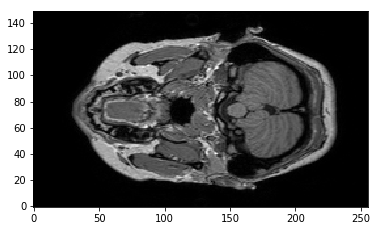

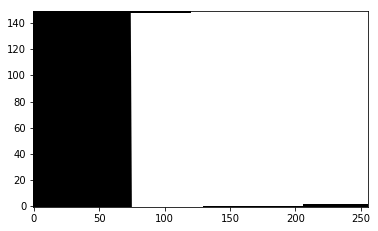

Resampled


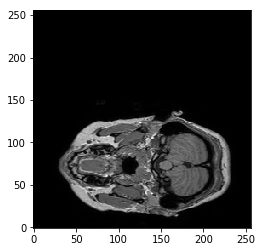

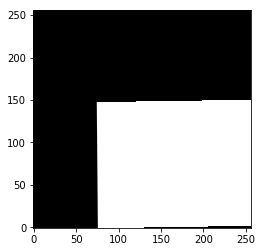

Converted Back to Normal


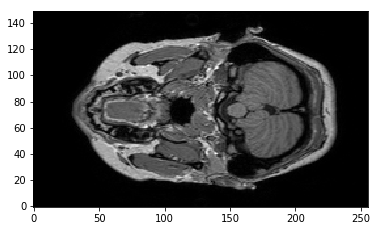

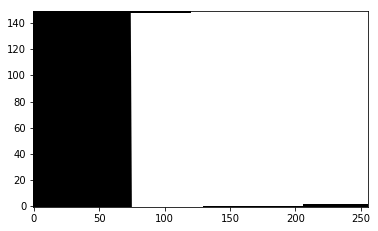

In [5]:
### Evaluate Resampling Results ###
slice_num = 75
## Normal images
norm_resample_data = norm_img_resampled1.get_data()
norm_img_recon_slice = norm_img_recon.get_data()
## Mask Images
mask_resample_data = mask_img_resampled1.get_data()
mask_img_recon_slice = mask_img_recon.get_data()
# Extract norm. slices to observe
norm_resample_slice = norm_resample_data[:, slice_num, :]
norm_img_slice = norm_img[:, slice_num, :]
norm_img_recon_slice = norm_img_recon_slice[:, slice_num, :]
# Extract mask slices to observe
mask_resample_slice = mask_resample_data[:, slice_num, :]
mask_img_slice = mask_img[:, slice_num, :]
mask_img_recon_slice = mask_img_recon_slice[:, slice_num, :]

print('Normal')
show_slice(norm_img_slice)
plt.show()
show_slice(mask_img_slice)
plt.show()
print('Resampled')
show_slice(norm_resample_slice)
plt.show()
show_slice(mask_resample_slice)
plt.show()
print('Converted Back to Normal')
show_slice(norm_img_recon_slice)
plt.show()
show_slice(mask_img_recon_slice)
plt.show()

In [6]:
### Comptue the mean squared error ###
from sklearn.metrics import mean_squared_error
print('##### Normal Input Image #####')
# Extract data
norm_img_mat = norm_img_nii.get_data()
norm_img_recon_mat = norm_img_recon.get_data()
# Compute the diff. metrics manhattan, mse
sum_diff = np.sum(np.absolute(norm_img_recon_mat - norm_img_mat))
mse = mean_squared_error(norm_img_recon_mat.flatten()
                         , norm_img_mat.flatten())
print('Compute manhattan distance : ', sum_diff)
print('Compute Mean Squared Error : ', mse)
print()
print('Statistics of original voxel values: ',
      stats.describe(norm_img_mat,axis=None))
print()
print('Statistics of reconstructed voxel values: ',
      stats.describe(norm_img_recon_mat, axis=None))
print()

##### Normal Input Image #####
Compute manhattan distance :  1.5511952e-09
Compute Mean Squared Error :  3.523045e-29

Statistics of original voxel values:  DescribeResult(nobs=9830400, minmax=(0, 1068), mean=105.87923960367839, variance=27339.047981425392, skewness=1.3435070240881604, kurtosis=0.5705360358377836)

Statistics of reconstructed voxel values:  DescribeResult(nobs=9830400, minmax=(0.0, 1068.0), mean=105.87918, variance=27339.043, skewness=1.3435086011886597, kurtosis=0.5705366800005724)



In [7]:
### Comptue the mean squared error ###
from sklearn.metrics import mean_squared_error
print('##### Mask Input Image #####')
# Extract data
mask_img_mat = mask_img_nii.get_data()
mask_img_recon_mat = mask_img_recon.get_data()
# Compute the diff. metrics manhattan, mse
sum_diff = np.sum(np.absolute(mask_img_recon_mat - mask_img_mat))
mse = mean_squared_error(mask_img_recon_mat.flatten()
                         , mask_img_mat.flatten())
print('Compute manhattan distance : ', sum_diff)
print('Compute Mean Squared Error : ', mse)
print()
print('Statistics of original voxel values: ',
      stats.describe(mask_img_mat,axis=None))
print()
print('Statistics of reconstructed voxel values: ',
      stats.describe(mask_img_recon_mat, axis=None))
print()

##### Mask Input Image #####
Compute manhattan distance :  0.0
Compute Mean Squared Error :  0.0

Statistics of original voxel values:  DescribeResult(nobs=9830400, minmax=(0.0, 1.0), mean=0.8313851494809853, variance=0.13970232572609326, skewness=-1.7702029257462208, kurtosis=1.1384420878912769)

Statistics of reconstructed voxel values:  DescribeResult(nobs=9830400, minmax=(0.0, 1.0), mean=0.8313851494809853, variance=0.13970232572609326, skewness=-1.7702029257462208, kurtosis=1.1384420878912769)



In [8]:
### Check if physical voxel size changed ###
print('### Input Image ###')
print('Original input physical voxel size : ',
      (norm_img_nii.header).get_zooms())
print('Original input sample physical voxel size : ',
      (norm_img_resampled1.header).get_zooms())
print('Original input recon. physical voxel size : ',
      (norm_img_recon.header).get_zooms())

print('### Mask Image ###')
print('Original input physical voxel size : ',
      (mask_img_nii.header).get_zooms())
print('Original input sample physical voxel size : ',
      (mask_img_resampled1.header).get_zooms())
print('Original input recon. physical voxel size : ',
      (mask_img_recon.header).get_zooms())




### Input Image ###
Original input physical voxel size :  (0.9375, 0.9375, 1.199997)
Original input sample physical voxel size :  (0.9375, 0.9375, 1.199997)
Original input recon. physical voxel size :  (0.9375, 0.9375, 1.199997)
### Mask Image ###
Original input physical voxel size :  (0.9375, 0.9375, 1.199997)
Original input sample physical voxel size :  (0.9375, 0.9375, 1.199997)
Original input recon. physical voxel size :  (0.9375, 0.9375, 1.199997)
